In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, f_classif
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeClassifier
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

In [2]:
df_test = pd.read_csv('dftest_cleaned.csv')
df_test.drop('Unnamed: 0', axis=1)
features = df_test[['hourly_basis', 'Age', 'category', 'amount_qt', 'merchant', 'job','transaction_id']]
target = df_test.is_fraud

In [3]:
# NOTE: Make sure that the outcome column is labeled 'target' in the data file
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, target, random_state=1)

In [4]:
# Average CV score on the training set was: 0.9982671062316886
exported_pipeline = make_pipeline(
    SelectPercentile(score_func=f_classif, percentile=44),
    VarianceThreshold(threshold=0.0001),
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="entropy", max_depth=9, min_samples_leaf=1, min_samples_split=14)),
    BernoulliNB(alpha=0.001, fit_prior=True)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 1)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

Text(0.5, 14.722222222222216, 'Predicted label')

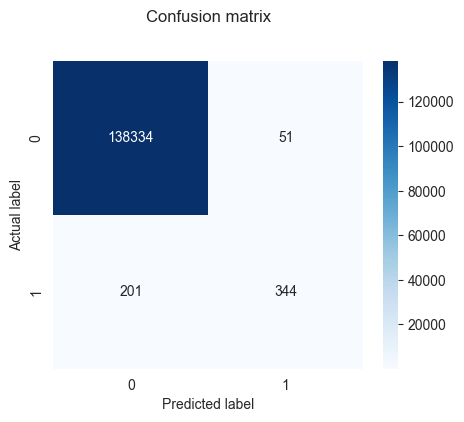

In [15]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
fig = plt.figure(figsize = (5,4))
cf_matrix = metrics.confusion_matrix(testing_target, results)
p = sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [9]:
from sklearn.metrics import classification_report,f1_score
# Run Classification Metrics
print("F1 Score :")
print(f1_score(testing_target, results, average='weighted'))
print("Classification Report :")
print(classification_report(testing_target,results))

F1 Score :
0.9980419050441202
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    138385
           1       0.87      0.63      0.73       545

    accuracy                           1.00    138930
   macro avg       0.93      0.82      0.87    138930
weighted avg       1.00      1.00      1.00    138930



#### In the case of fraud detection, it is important to have a high recall score as it would indicate the prediction of fraud cases.

    **Recall = TP/TP+FN**
    **F1-score = 2 x [Precision x Recall/(Precision + Recall)]**

#### A high F1- score will indicate that model is performing ok. Our aim in tuning this model should be focused on it somehow increasing Recall & F1 Scores**

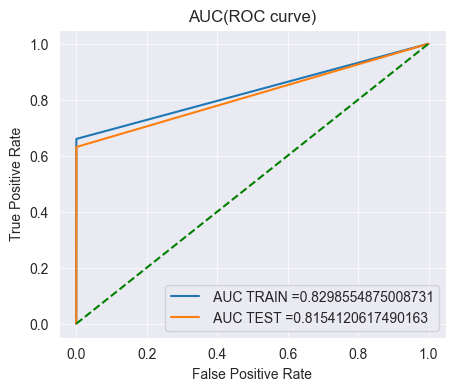

In [16]:
from sklearn.metrics import roc_curve, auc

y_train_pred = exported_pipeline.predict(training_features)    
y_test_pred = exported_pipeline.predict(testing_features) 

train_fpr, train_tpr, tr_thresholds = roc_curve(training_target, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(testing_target, y_test_pred)

# plot ROC curve
fig = plt.figure(figsize=(5,4))

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid( linestyle='-', linewidth=0.5)
plt.show()

In [18]:
error = (y_test_pred != testing_target).sum()
error

252